# Coursework 1: Flight Prediciton (Samuel Hope)

## Import Data and Dependancies

In [17]:
import pandas as pd
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, randint
from sklearn.model_selection import train_test_split,  cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

Due to the high volumns of the data we will only import the features that we have previously found to be descriptive for a flight disruption. Due to the missing quotation marks in the csv files we built a custom function to read the data using the indeces of the columns.

In [2]:
features = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Disruption']
features_index = [1,2,3,4,6,7,8,9,11,44]

def import_large(path, features, features_index):   
    data = pd.read_csv(path)
    data.reset_index(inplace=True)
    data = data.iloc[:,features_index]
    data.columns = features
    return data
    
path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
test_csv_names = ['Combined_Flights_train_2018.csv',
                  'Combined_Flights_train_2020.csv',
                  'Combined_Flights_train_2021.csv',
                  'Combined_Flights_train_2022.csv'] 
data = []
for csv_name in test_csv_names:
    full_path = path_to_data + csv_name
    year_data = pd.read_csv(full_path,usecols=features)
    data.append(year_data)

#We need to handle 2019 data seperately as it has no 'Disruption' column
year_data = pd.read_csv('/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2019.csv',
                        usecols = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Cancelled','Diverted','ArrDel15'])
year_data['Disruption'] = year_data.apply(lambda row: 1 if row['Diverted'] or row['Cancelled'] or row['ArrDel15']>0 else 0, axis=1)
year_data = year_data.drop(['Diverted', 'Cancelled', 'ArrDel15'],axis=1)
data.append(year_data)

flights_raw = pd.concat(data,ignore_index=True)
display(flights_raw);

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
0,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,2,0.0
1,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,4,0.0
2,Endeavor Air Inc.,ABY,ATL,1400,145,2018,1,1,6,0.0
3,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,7,1.0
4,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...
23355023,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,3,0.0
23355024,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,4,0.0
23355025,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,5,0.0
23355026,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,6,0.0


## Data Exploration

In [3]:
# Replace values that have a string 'NA' instead of a NA with NA
flights_raw.replace('NA',pd.NA, inplace=True)

data_summary = pd.concat([flights_raw.count().to_frame('total'),
                          flights_raw.nunique().to_frame(name='nunique'),
                          flights_raw.isna().sum().to_frame(name='isna'),
                          flights_raw.dtypes.to_frame(name='Dtype')],axis=1)

display(data_summary);

,total,nunique,isna,Dtype
Airline,23355028,28,0,object
Origin,23355028,388,0,object
Dest,23355028,388,0,object
CRSDepTime,23355028,1423,0,int64
Distance,23355028,1740,0,int64
Year,23355028,5,0,int64
Quarter,23355028,4,0,int64
Month,23355028,12,0,int64
DayOfWeek,23355028,7,0,int64
Disruption,23354579,2,449,float64


In [4]:
mask = flights_raw.isnull().any(axis=1)
display(flights_raw[mask]);

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Disruption
6,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,3,NaN
27,Endeavor Air Inc.,ATL,ABY,1037,145,2018,1,1,1,NaN
40,Endeavor Air Inc.,ATL,EVV,939,350,2018,1,1,4,NaN
56,Endeavor Air Inc.,DFW,DTW,730,986,2018,1,1,2,NaN
82,Endeavor Air Inc.,ATL,EWN,1225,433,2018,1,1,3,NaN
...,...,...,...,...,...,...,...,...,...,...
2728843,Endeavor Air Inc.,BNA,BOS,1855,942,2018,2,4,2,NaN
2728883,Endeavor Air Inc.,DTW,AVP,1545,399,2018,2,4,3,NaN
2728969,Endeavor Air Inc.,JAX,LGA,704,833,2018,2,4,3,NaN
5295479,Republic Airlines,DTW,IND,830,231,2020,1,3,3,NaN


There are some missing values in the `'Disruption'` column. These all seem to come from the airlines 'Endeavor Air Inc.' and 'Republic Airlines', so there has probably been some issue with data collection. Since the missing values are in the feature we are trying to predict we will simply drop the correspoonding rows.

In [5]:
flights_raw = flights_raw.dropna()
del data_summary

### Airlines

From experience it seems reasonable to believe that some airlines are more likely to have disrupted flights than others. We can see in the above table that `'Airlines'` is a categorical column with 28 unique features. We will use the chi-squared contigency test and frequency plots to investigate this behaviour. The chi-squred contingency test tests the null hypothesis of the two features (`'Airline'` and `'Disruption'` in this case) being independent.

,Variable,Value
0,Chi-square,175033.3695
1,p-value,0.0000
2,Degrees of Freedom,27.0000


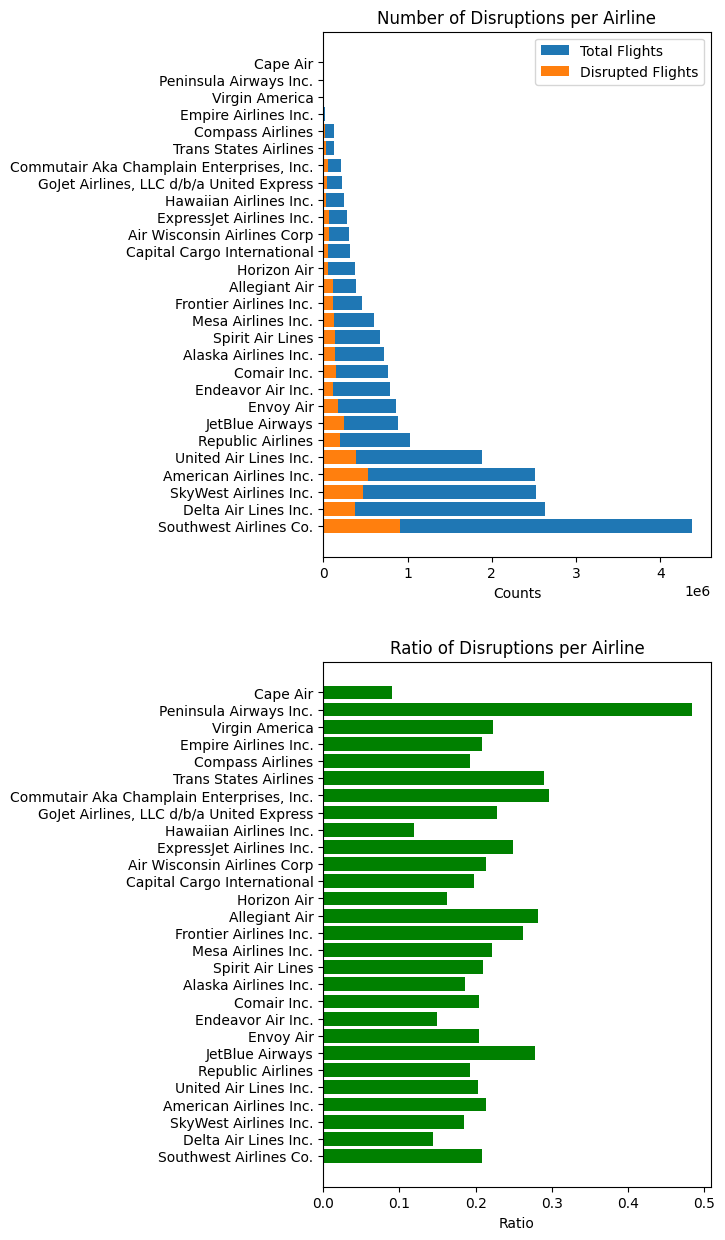

In [9]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Airline'],flights_raw['Disruption'])
chi2, p, dof, expexcted = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})



airline_data = pd.merge(flights_raw['Airline'].value_counts(),flights_raw.groupby('Airline')['Disruption'].sum(),left_index=True, right_index=True)
airline_data.columns = ["Flights","Disruptions"]
airline_data['Ratio'] = airline_data['Disruptions']/airline_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(5,15))
ax1.barh(airline_data.index, airline_data['Flights'],label='Total Flights')
ax1.barh(airline_data.index, airline_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions per Airline')
ax1.set_xlabel('Counts')
ax1.legend()


ax2.barh(airline_data.index, airline_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions per Airline')
ax2.set_xlabel('Ratio')
display(chi2_results);

In [85]:
airline_data.loc['Peninsula Airways Inc.']

Flights        2219.000000
Disruptions    1075.000000
Ratio             0.484452
Name: Peninsula Airways Inc., dtype: float64

As expected the feature `'Airline'` seems to be a good predicter for a disruption. The rate of disruptions varies noticably between airlines and the chi-squared contingency test gives a p-value of about 0, meaning we conclude a relationship between `'Airline'` and `'Disruption'`. We notice that the airline 'Peninsula Airways Inc.' stands out as an outlier with a rate of disruption of 0.47695. We only have 564 observations of this airline so we expect there to be more variability in this ratio. We have other airlines with a low frequency in the data that have significantly lower rates of disruption. There doesn't seem to be a reasonable way to group airlines to reduce the number of unique categories, and since there is no logical order to the airlines, label encoding would not make sense as a method of encoding this feature. Even though 28 is quite a high number of unique categories for one-hot encoding, we will proceed with this method as this seems to be an important feature to include in the model.

### Year, Month, Quarter

,Variable,Year,Quarter,Month
0,Chi-square,97675.431367,34293.951703,104452.466686
1,p-value,0.000000,0.000000,0.000000
2,Degrees of Freedom,4.000000,3.000000,11.000000


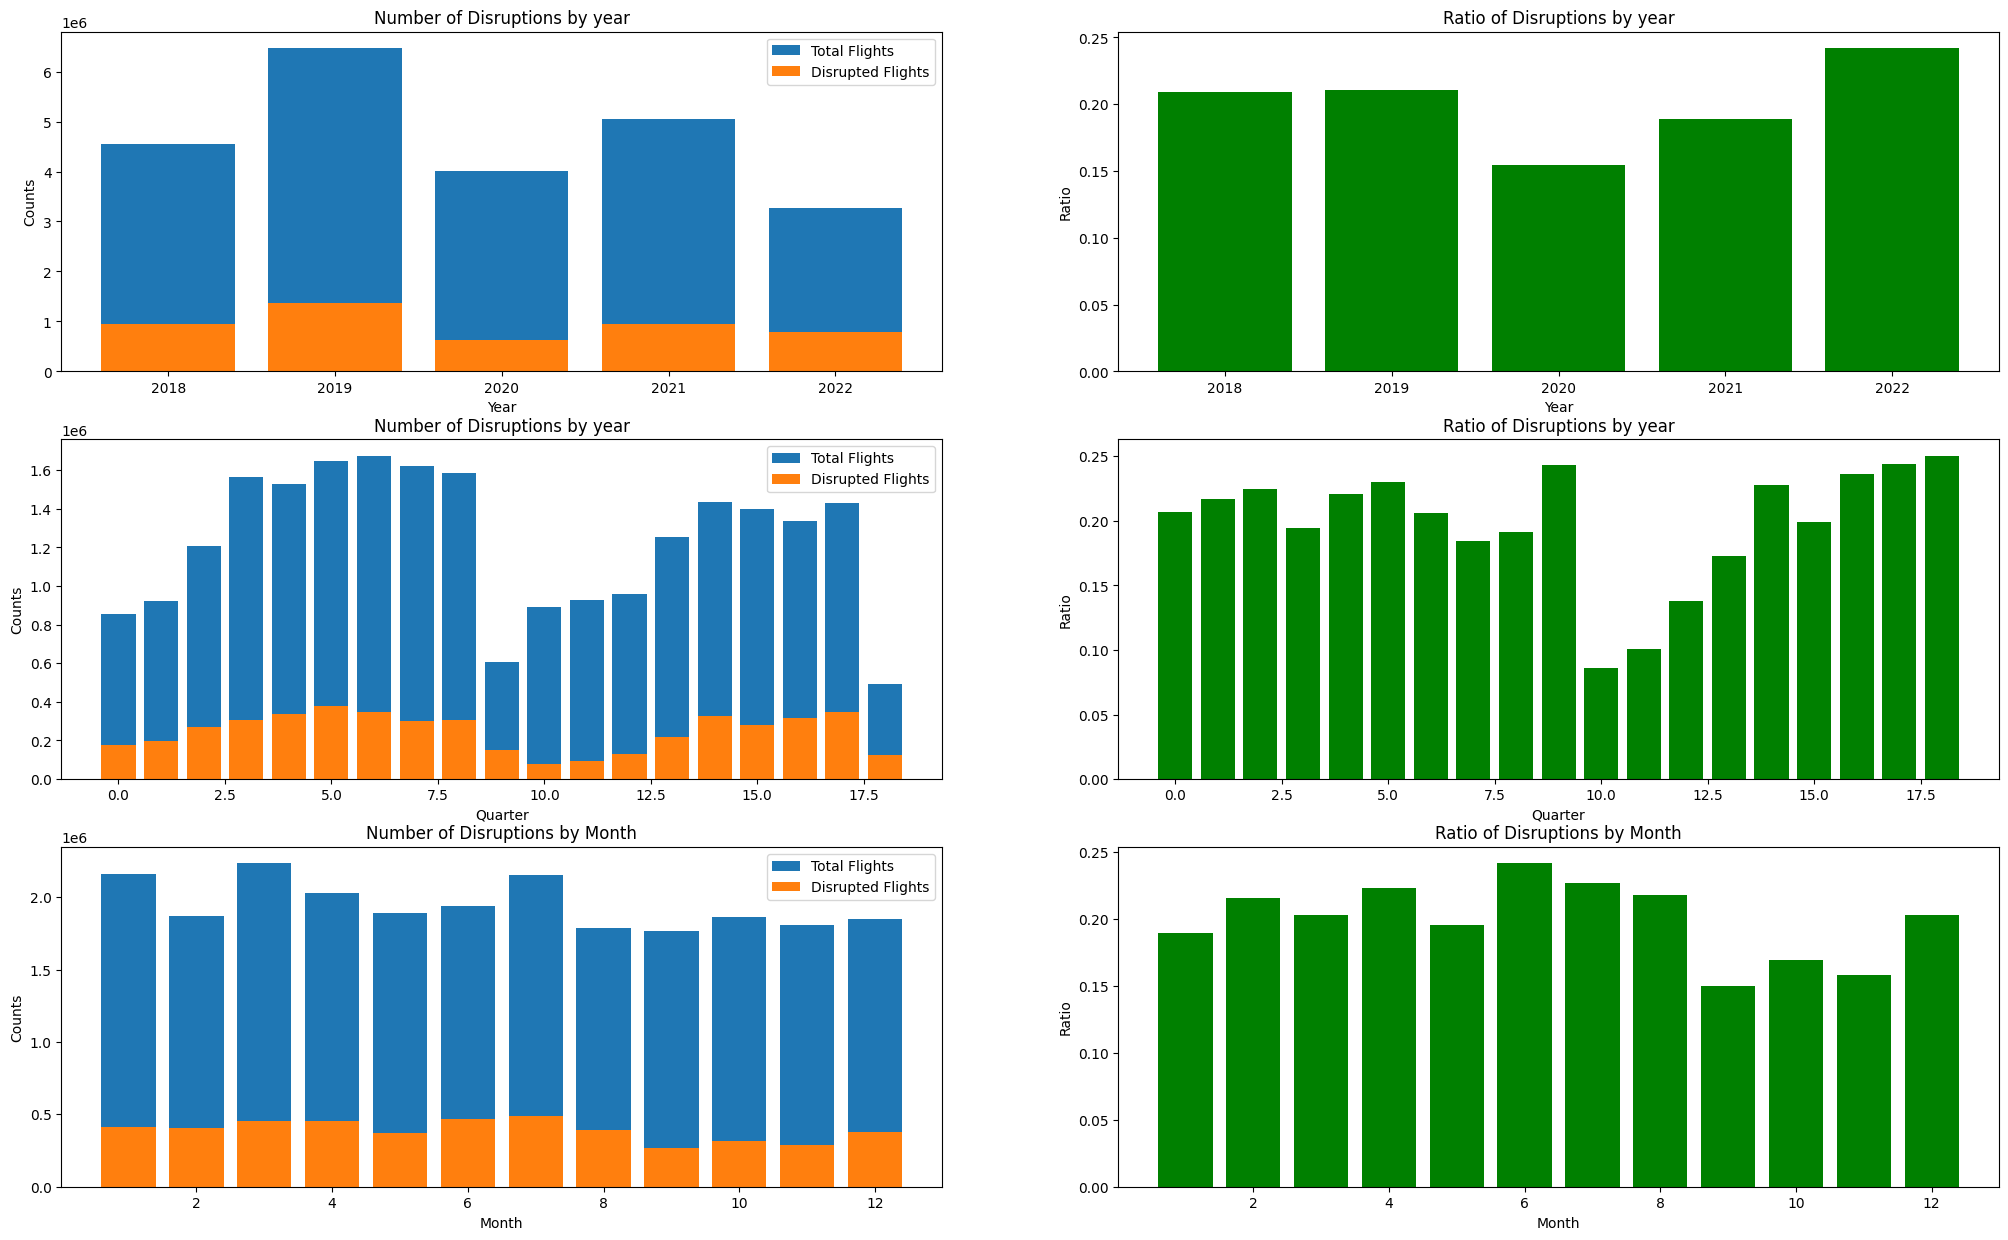

In [10]:
#Conduct chi-squared contingency test for features
chi2_year, p_year, dof_year, expected = chi2_contingency(pd.crosstab(flights_raw['Year'],flights_raw['Disruption']))
chi2_quarter, p_quarter, dof_quarter, expected = chi2_contingency(pd.crosstab(flights_raw['Quarter'],flights_raw['Disruption']))
chi2_month, p_month, dof_month, expected = chi2_contingency(pd.crosstab(flights_raw['Month'],flights_raw['Disruption']))
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Year': [chi2_year, p_year, dof_year],
    'Quarter': [chi2_quarter, p_quarter, dof_quarter],
    'Month': [chi2_month, p_month, dof_month]
})

#Calculate yearly data for plot
year_data = pd.merge(flights_raw['Year'].value_counts(),flights_raw.groupby('Year')['Disruption'].sum(),left_index=True, right_index=True)
year_data.columns = ["Flights","Disruptions"]
year_data['Ratio'] = year_data['Disruptions']/year_data['Flights']

#Calculate quartely
quarter_data = pd.merge(flights_raw.groupby(['Year','Quarter']).size().reset_index(name='Flights'),
         flights_raw.groupby(['Year','Quarter'])['Disruption'].sum().reset_index(name='Disruptions'),
         left_index=True, right_index=True)
quarter_data['Ratio'] = quarter_data['Disruptions']/quarter_data['Flights']

#Calculate monthly data
month_data = pd.merge(flights_raw['Month'].value_counts(),flights_raw.groupby('Month')['Disruption'].sum(),left_index=True, right_index=True)
month_data.columns = ["Flights","Disruptions"]
month_data['Ratio'] = month_data['Disruptions']/month_data['Flights']


fig, ((ax11,ax12),(ax21,ax22),(ax31,ax32)) = plt.subplots(nrows=3,ncols=2,figsize=(25,15))
ax11.bar(year_data.index, year_data['Flights'],label='Total Flights')
ax11.bar(year_data.index, year_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by year')
ax11.set_xlabel('Year')
ax11.set_ylabel('Counts')
ax11.legend()


ax12.bar(year_data.index, year_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by year')
ax12.set_xlabel('Year')
ax12.set_ylabel('Ratio')

ax21.bar(quarter_data.index, quarter_data['Flights'],label='Total Flights')
ax21.bar(quarter_data.index, quarter_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by year')
ax21.set_xlabel('Quarter')
ax21.set_ylabel('Counts')
ax21.legend()


ax22.bar(quarter_data.index, quarter_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by year')
ax22.set_xlabel('Quarter')
ax22.set_ylabel('Ratio')

ax31.bar(month_data.index, month_data['Flights'],label='Total Flights')
ax31.bar(month_data.index, month_data['Disruptions'], label='Disrupted Flights')
ax31.set_title('Number of Disruptions by Month')
ax31.set_xlabel('Month')
ax31.set_ylabel('Counts')
ax31.legend()


ax32.bar(month_data.index, month_data['Ratio'],color="green")
ax32.set_title('Ratio of Disruptions by Month')
ax32.set_xlabel('Month')
ax32.set_ylabel('Ratio')
display(chi2_results)

### Day of Week, Time of Day

,Variable,DayOfWeek,TimeOfDay
0,Chi-square,24720.764935,376049.311374
1,p-value,0.000000,0.000000
2,Degrees of Freedom,6.000000,23.000000


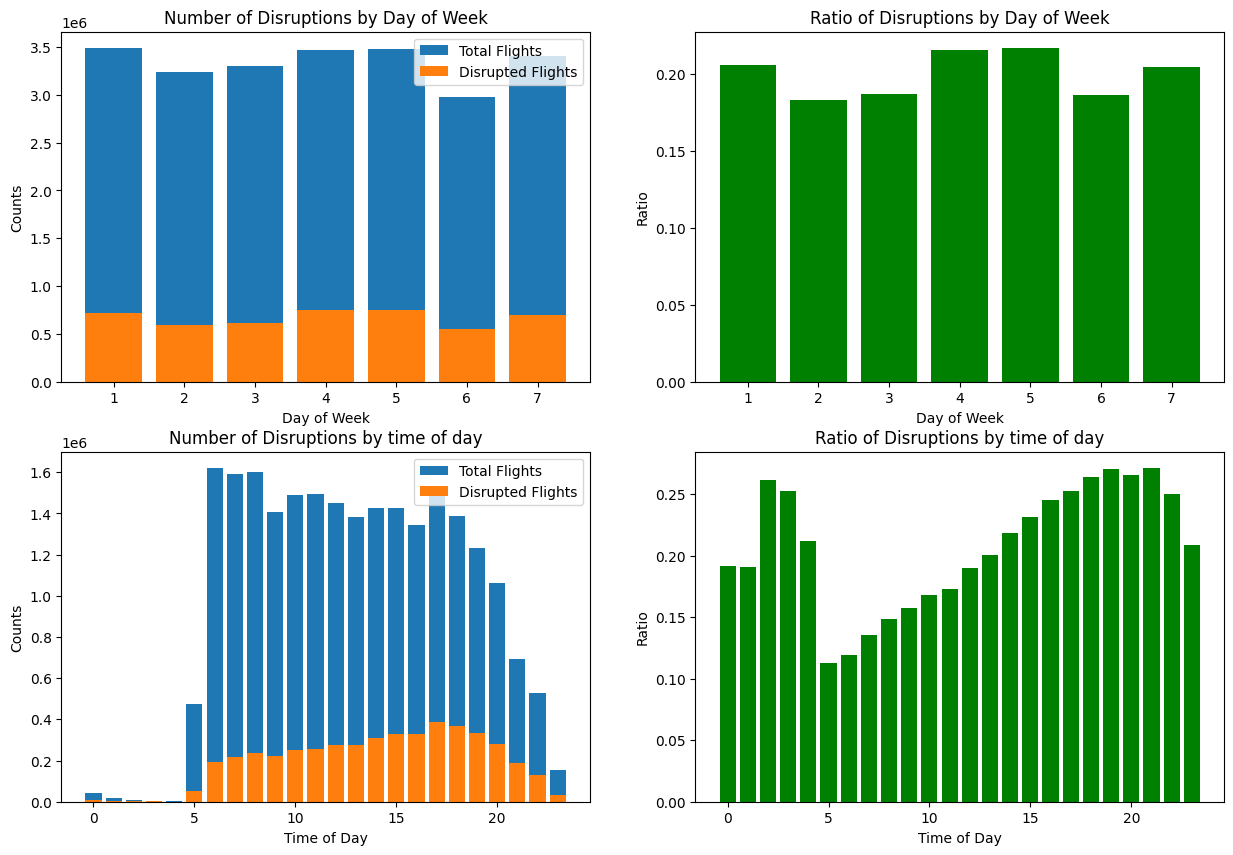

In [24]:
flights_raw['TimeOfDay'] = flights_raw['CRSDepTime'] // 100

#Chi-square test
crosstab = pd.crosstab(flights_raw['DayOfWeek'],flights_raw['Disruption'])
chi2_day, p_day, dof_day, expected = chi2_contingency(crosstab)
crosstab = pd.crosstab(flights_raw['TimeOfDay'],flights_raw['Disruption'])
chi2_time, p_time, dof_time, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'DayOfWeek': [chi2_day, p_day, dof_day],
    'TimeOfDay': [chi2_time, p_time, dof_time]
})

day_data = pd.merge(flights_raw['DayOfWeek'].value_counts(),
                     flights_raw.groupby('DayOfWeek')['Disruption'].sum(),
                     left_index=True, right_index=True)
day_data.columns = ["Flights","Disruptions"]
day_data['Ratio'] = day_data['Disruptions']/day_data['Flights']


time_data = pd.merge(flights_raw['TimeOfDay'].value_counts(),
                     flights_raw.groupby('TimeOfDay')['Disruption'].sum(),
                     left_index=True, right_index=True)
time_data.columns = ["Flights","Disruptions"]
time_data['Ratio'] = time_data['Disruptions']/time_data['Flights']

fig, ((ax11,ax12),(ax21,ax22)) = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

ax11.bar(day_data.index, day_data['Flights'],label='Total Flights')
ax11.bar(day_data.index, day_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by Day of Week')
ax11.set_xlabel('Day of Week')
ax11.set_ylabel('Counts')
ax11.legend()


ax12.bar(day_data.index, day_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by Day of Week')
ax12.set_xlabel('Day of Week')
ax12.set_ylabel('Ratio')


ax21.bar(time_data.index, time_data['Flights'],label='Total Flights')
ax21.bar(time_data.index, time_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by time of day')
ax21.set_xlabel('Time of Day')
ax21.set_ylabel('Counts')
ax21.legend()


ax22.bar(time_data.index, time_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by time of day')
ax22.set_xlabel('Time of Day')
ax22.set_ylabel('Ratio')

display(chi2_results)

### Origin Airport and Destination Airport 

In [ ]:
origin_data = pd.merge(flights_raw['Origin'].value_counts(),
                       flights_raw.groupby('Origin')['Disruption'].sum(),
                       left_index=True, right_index=True)
origin_data.columns = ["Flights", "Disruptions"]
origin_data['Ratio'] = origin_data['Disruptions']/origin_data['Flights']

dest_data = pd.merge(flights_raw['Dest'].value_counts(),
                       flights_raw.groupby('Dest')['Disruption'].sum(),
                       left_index=True, right_index=True)
dest_data.columns = ["Flights", "Disruptions"]
dest_data['Ratio'] = dest_data['Disruptions']/dest_data['Flights']

fig, (ax11,ax21), (ax21,ax22) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

ax11.bar(origin_data.index, origin_data['Flights'],label='Total Flights')
ax11.bar(origin_data.index, origin_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by origin airport')
ax11.set_xlabel('Origin Airport')
ax11.set_ylabel('Counts')
ax11.legend()
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax12.bar(origin_data.index, origin_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by origin airport')
ax12.set_xlabel('Origin Airport')
ax12.set_ylabel('Ratio')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax21.bar(dest_data.index, dest_data['Flights'],label='Total Flights')
ax21.bar(dest_data.index, dest_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by origin airport')
ax21.set_xlabel('Origin Airport')
ax21.set_ylabel('Counts')
ax21.legend()
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax22.bar(dest_data.index, dest_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by origin airport')
ax22.set_xlabel('Origin Airport')
ax22.set_ylabel('Ratio')
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

### Distance

In [ ]:
#Split the distances into 10 groups
flights_raw['Distance_Group'] = pd.cut(flights_raw['Distance'], bins=15,labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
distance_data = pd.merge(flights_raw['Distance_Group'].value_counts(),flights_raw.groupby('Distance_Group')['Disruption'].sum(),left_index=True, right_index=True)
distance_data.columns = ["Flights","Disruptions"]


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(distance_data.index,distance_data['Flights'], label='Total Flights')
ax1.bar(distance_data.index,distance_data['Disruptions'],label='Disrupted Flights')
ax1.set_xlabel('Flight Distance')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Number of Disrupted Flights by Distance')
ax1.legend()

ax2.bar(distance_data.index,distance_data['Disruptions']/distance_data['Flights'], label='Ratio',color='green')
ax2.set_xlabel('Flight Distance')
ax2.set_ylabel('Ratio')
ax2.set_title('Ratio of Disrupted Flights by Distance')
ax2.legend()

flights_raw[['Distance','Disruption']].corr()

### Summary

In [ ]:
del time_data
del day_data
del distance_data
del origin_data
del dest_data
del airline_data
del quarter_data
del year_data

## Feature Engineering and Preprocessing

In [6]:
#Drop missing values
flights = flights_raw.dropna()

#Rename 'CRSDepTime' column to 'TimeOfDay'
flights.rename({'CRSDepTime':'TimeOfDay'},axis=1, inplace=True)

#Make 'Route' column
flights['Route'] = flights['Origin'] + '->' + flights['Dest']

#List of features to include in our model
features = ['Airline', 'Route', 'TimeOfDay', 'Month', 'Disruption']


#Group features by how we will encode them
cyclical_encode_features = ['TimeOfDay',  'Month']
target_encode_features = ['Route', 'Airline']

#Define a custom encoder for the 'TimeOfDay' feature. This will preserve distances between times of day.
class CyclicalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['Time_sin'] = np.sin(2 * np.pi * X_transformed['TimeOfDay'] / 2400)
        X_transformed['Time_cos'] = np.cos(2 * np.pi * X_transformed['TimeOfDay'] / 2400)
        X_transformed['Month_sin'] = np.sin(2 * np.pi * X_transformed['Month'] / 7)
        X_transformed['Month_cos'] = np.cos(2 * np.pi * X_transformed['Month'] / 7)
        return X_transformed.drop(['TimeOfDay', 'Month'], axis=1)
        
    def fit_transform(self, X, y=None):
        return self.transform(X)

#Define training set and split of labels
X = flights[features].drop('Disruption', axis = 1)
y = flights['Disruption']

#Define training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=17)


#Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), target_encode_features),
        ('cyclical', CyclicalTransformer(), cyclical_encode_features),
    ],
    remainder='passthrough'
)
del flights_raw
del X
del y

In [19]:
%whos

Variable                         Type                 Data/Info
---------------------------------------------------------------
BaseEstimator                    type                 <class 'sklearn.base.BaseEstimator'>
ColumnTransformer                ABCMeta              <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
CyclicalTransformer              type                 <class '__main__.CyclicalTransformer'>
GridSearchCV                     ABCMeta              <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
HistGradientBoostingClassifier   ABCMeta              <class 'sklearn.ensemble.<...>dientBoostingClassifier'>
KFold                            ABCMeta              <class 'sklearn.model_selection._split.KFold'>
LogisticRegression               type                 <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
OneHotEncoder                    type                 <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
OrdinalEncoder                   type

## Model Training and Hyperparameter Tuning

#### Model 1: Stochastic Gradient Descent 

In [68]:
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss = 'log_loss', n_jobs=-1))
])

sgd_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['Route', 'Airline']),
                                                 ('cyclical',
                                                  CyclicalTransformer(),
                                                  ['TimeOfDay', 'Month'])])),
                ('classifier', SGDClassifier(loss='log_loss', n_jobs=-1))])

Precision: 0.75
Recall: 0.0002582866982350409
f1-score: 0.0005163955589981927
Accuracy: 0.801101281974429
Log Loss: 7.159903949718039


<Axes: >

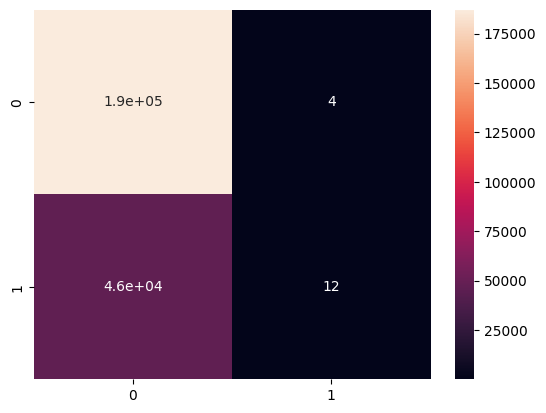

In [69]:
y_scores_sgd = sgd_pipeline.decision_function(X_val)
y_predictions_sgd = np.where(y_scores_sgd>0.5,1,0)
conf_mat = confusion_matrix(y_val, y_predictions_sgd)
precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:]) if sum(conf_mat[1,:])>0 else 'Undefined'
f1_score = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 'Undefined'
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
logloss = log_loss(y_val, y_scores_sgd) 


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
print(f'Log Loss: {logloss}')
sns.heatmap(conf_mat, annot=True)

#### Model 2: Random Forest Classifier

In [13]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=10,
                                          max_depth=15,
                                          min_samples_leaf=5,
                                          n_jobs=-1))
])

rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['Route', 'Airline']),
                                                 ('cyclical',
                                                  CyclicalTransformer(),
                                                  ['TimeOfDay', 'Month'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        n_estimators=10, n_jobs=-1))])

Precision: 0.5739130434782609
Recall: 0.0113646147223418
f1-score: 0.022287885183621778
Accuracy: 0.8016493538746114
Log Loss: 0.4773314505007062


<Axes: >

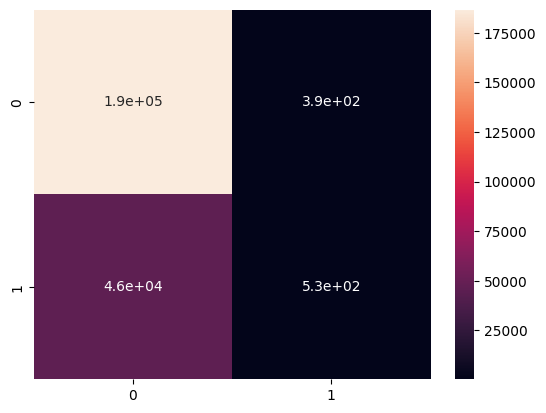

In [42]:
threshold = 0.5

y_scores_rf = rf_pipeline.predict_proba(X_val)
y_predictions_rf = np.where(y_scores_rf[:,1]>=threshold,1,0)
conf_mat = confusion_matrix(y_val, y_predictions_rf)

precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall)
logloss = log_loss(y_val, y_scores_rf) 

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
print(f'Log Loss: {logloss}')
sns.heatmap(conf_mat, annot=True)

#### Model 3 Hist Gradient Boosting Classifier

In [63]:
hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier())
])

hgb_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['Route', 'Airline']),
                                                 ('cyclical',
                                                  CyclicalTransformer(),
                                                  ['TimeOfDay', 'Month'])])),
                ('classifier', HistGradientBoostingClassifier())])

Precision: Undefined
Recall: 0.0
f1-score: Undefined
Accuracy: 0.8010670274806676
Log Loss: 7.128299483934355


<Axes: >

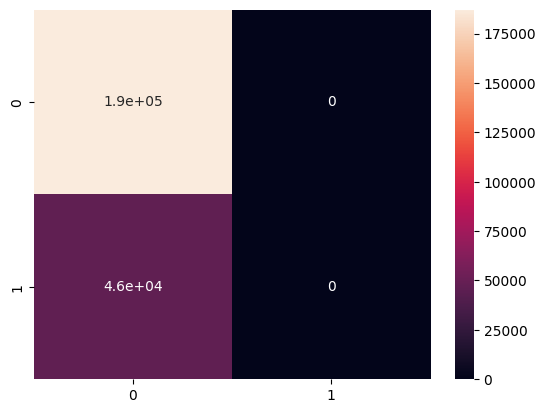

In [66]:
y_scores_hgb = hgb_pipeline.decision_function(X_val)
y_predictions_hgb = np.where(y_scores_hgb>=threshold,1,0)
conf_mat = confusion_matrix(y_val, y_predictions_hgb)

precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall) if precision!='Undefined' else 'Undefined'
logloss = log_loss(y_val, y_scores_hgb)


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
print(f'Log Loss: {logloss}')
sns.heatmap(conf_mat, annot=True)

## Model Evaluation

#### Lift Curve

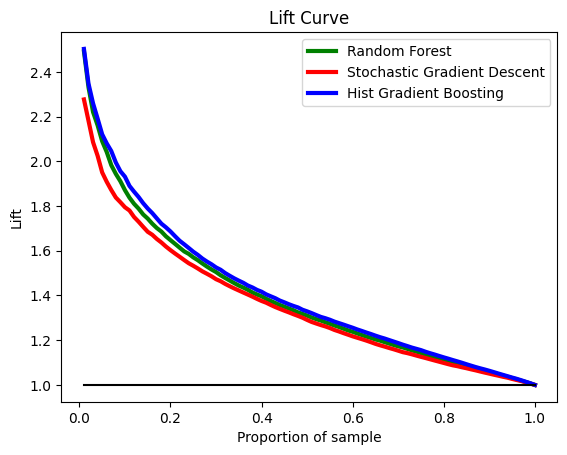

In [26]:
def calc_lift(y_val, y_pred, step=0.01):
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted',ascending=False,inplace=True)  # Order the values for the predicted probability column   
    x_val = np.arange(step,1+step,step) # Create the values that will go into the X axis of our plot
    ratio_ones = aux_lift['real'].sum() / len(aux_lift) # Calculate the ratio of ones in our data
    y_v = []
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) 
        data_here = aux_lift.iloc[:num_data,:]
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val, y_v


sample_prop, lift_rf = calc_lift(y_val, y_scores_rf[:,1], step=0.01)
sample_prop, lift_sgd = calc_lift(y_val, y_scores_sgd, step=0.01)
sample_prop, lift_hgb = calc_lift(y_val, y_scores_hgb, step=0.01)

#Plot the figure
fig, axis = plt.subplots()
fig.figsize = (40,40)
axis.plot(sample_prop, lift_rf, 'g-', linewidth = 3, markersize = 5, label='Random Forest')
axis.plot(sample_prop, lift_sgd, 'r-', linewidth = 3, markersize = 5, label='Stochastic Gradient Descent')
axis.plot(sample_prop, lift_hgb, 'b-', linewidth = 3, markersize = 5, label='Hist Gradient Boosting')
axis.plot(sample_prop, np.ones(len(sample_prop)), 'k-')
axis.set_xlabel('Proportion of sample')
axis.set_ylabel('Lift')
plt.legend()
plt.title('Lift Curve')
plt.show()

#### ROC Curve

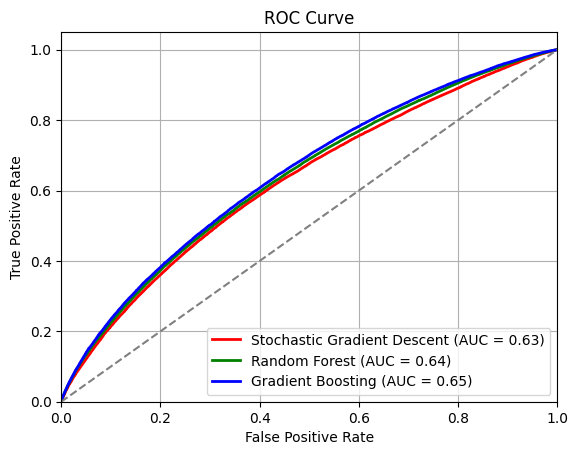

In [27]:
fpr_sgd, tpr_sgd, thresholds = roc_curve(y_val, y_scores_sgd)
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_scores_rf[:,1])
fpr_hgb, tpr_hgb, thresholds = roc_curve(y_val, y_scores_hgb)

# Compute AUC (Area Under the Curve)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)
roc_auc_hgb = auc(fpr_hgb, tpr_hgb)


# Plot ROC curve
plt.plot(fpr_sgd, tpr_sgd, color='red', lw=2, label='Stochastic Gradient Descent (AUC = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_hgb, tpr_hgb, color='blue', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_hgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Precision Recall vs Threshold curve

/tmp/ipykernel_4377/1259110871.py:7: RuntimeWarning: invalid value encountered in divide
  f1_scores_hgb = 2 * precisions_hgb * recalls_hgb / (precisions_hgb + recalls_hgb)


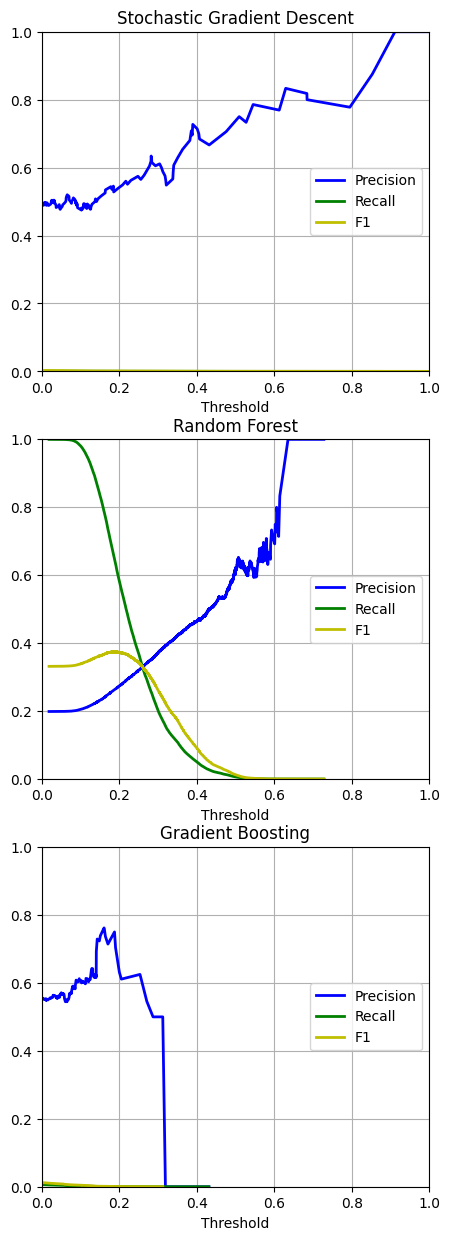

In [70]:
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_val, y_scores_rf[:,1])
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_val, y_scores_sgd)
precisions_hgb, recalls_hgb, thresholds_hgb = precision_recall_curve(y_val, y_scores_hgb)

f1_scores_rf = 2 * precisions_rf * recalls_rf / (precisions_rf + recalls_rf)
f1_scores_sgd = 2 * precisions_sgd * recalls_sgd / (precisions_sgd + recalls_sgd)
f1_scores_hgb = 2 * precisions_hgb * recalls_hgb / (precisions_hgb + recalls_hgb)




fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1,figsize=(5,15))
ax1.plot(
    thresholds_sgd,
    precisions_sgd[:-1], "b",
    label="Precision",
    linewidth=2)
ax1.plot(
    thresholds_sgd,
    recalls_sgd[:-1], "g",
    label="Recall",
    linewidth=2)
ax1.plot(
    thresholds_sgd,
    f1_scores_sgd[:-1], "y",
    label="F1",
    linewidth=2)
ax1.legend(loc="center right", fontsize=10)
ax1.set_xlabel("Threshold", fontsize=10)
ax1.grid(True)
ax1.axis([0, 1, 0, 1])
ax1.set_title('Stochastic Gradient Descent')

ax2.plot(
    thresholds_rf,
    precisions_rf[:-1], "b",
    label="Precision",
    linewidth=2)
ax2.plot(
    thresholds_rf,
    recalls_rf[:-1], "g",
    label="Recall",
    linewidth=2)
ax2.plot(
    thresholds_rf,
    f1_scores_rf[:-1], "y",
    label="F1",
    linewidth=2)
ax2.legend(loc="center right", fontsize=10)
ax2.set_xlabel("Threshold", fontsize=10)
ax2.grid(True)
ax2.axis([0, 1, 0, 1])
ax2.set_title('Random Forest')

ax3.plot(
    thresholds_hgb,
    precisions_hgb[:-1], "b",
    label="Precision",
    linewidth=2)
ax3.plot(
    thresholds_hgb,
    recalls_hgb[:-1], "g",
    label="Recall",
    linewidth=2)
ax3.plot(
    thresholds_hgb,
    f1_scores_hgb[:-1], "y",
    label="F1",
    linewidth=2)

ax3.legend(loc="center right", fontsize=10)
ax3.set_xlabel("Threshold", fontsize=10)
ax3.grid(True)
ax3.axis([0, 1, 0, 1])
ax3.set_title('Gradient Boosting');

In [ ]:
del sgd_pipeline
del hgb_pipeline

### Hyperparameter Tuning

In [58]:
param_dist = {
    'classifier__n_estimators': randint(5,25),
    'classifier__max_depth': randint(5,25),
    'classifier__min_samples_split': randint(2,10),
    'classifier__min_samples_leaf': randint(1,10)
}
flights_gscv_subsample  = flights.sample(n=1000000, random_state=17)
X_subsample = flights_gscv_subsample[features].drop('Disruption', axis = 1)
y_subsample = flights_gscv_subsample['Disruption']


rand_search = RandomizedSearchCV(estimator = rf_pipeline, param_distributions=param_dist, cv=3, n_iter=36, scoring='accuracy', n_jobs=-1)
rand_search.fit(X_subsample, y_subsample)

best_params_rf, best_score_rf = rand_search.best_params_, rand_search.best_score_
best_params_rf, best_score_rf

/cs/home/slh27/Documents/ID5059Project1/myenvID5059/lib64/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'classifier__max_depth': 12,
  'classifier__min_samples_leaf': 6,
  'classifier__min_samples_split': 3,
  'classifier__n_estimators': 23},
 0.7996909999345995)

In [59]:
rf_pipeline.set_params(**best_params_rf)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['Route', 'Airline']),
                                                 ('cyclical',
                                                  CyclicalTransformer(),
                                                  ['TimeOfDay', 'Month'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=6,
                                        min_samples_split=3, n_estimators=23,
                                        n_jobs=-1))])

Precision: 0.6101010101010101
Recall: 0.006500215238915196
f1-score: 0.012863379831753806
Accuracy: 0.8015337449581666
Log Loss: 0.4783942830165793


<Axes: >

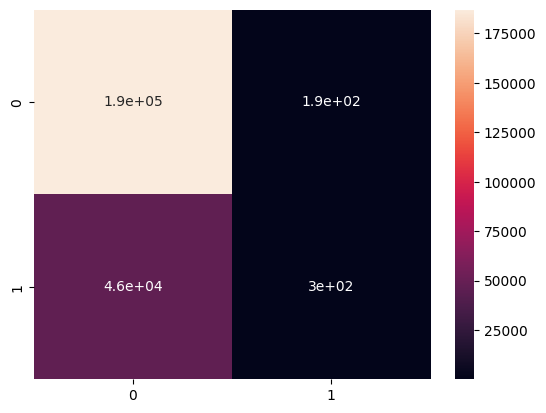

In [60]:
rf_pipeline.set_params(**best_params_rf)
threshold = 0.5
y_scores_rf = rf_pipeline.predict_proba(X_val)
y_predictions_rf = np.where(y_scores_rf[:,1]>=threshold,1,0)
conf_mat = confusion_matrix(y_val, y_predictions_rf)

precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall)
logloss = log_loss(y_val, y_scores_rf) 

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
print(f'Log Loss: {logloss}')
sns.heatmap(conf_mat, annot=True)

### Evaluation

#### Load Test Data

In [71]:
del flights
del X_train
del y_train
del X_val
del y_val

In [75]:
def import_large(path, features, features_index):   
    data = pd.read_csv(path)
    data.reset_index(inplace=True)
    data = data.iloc[:,features_index]
    data.columns = features
    return data
    
path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
test_csv_names = ['Combined_Flights_test_2018.csv',
                  'Combined_Flights_test_2019.csv',
                  'Combined_Flights_test_2020.csv',
                  'Combined_Flights_test_2021.csv',
                  'Combined_Flights_test_2022.csv'] 
data = []
for csv_name in test_csv_names:
    full_path = path_to_data + csv_name
    year_data = import_large(full_path,['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Disruption'],features_index)
    data.append(year_data)
flights_test = pd.concat(data,ignore_index=True)
flights_test = flights_test.dropna()

#Rename 'CRSDepTime' column to 'TimeOfDay'
flights_test.rename({'CRSDepTime':'TimeOfDay'},axis=1, inplace=True)

#Make 'Route' column
flights_test['Route'] = flights_test['Origin'] + '->' + flights_test['Dest']


flights_test = flights_test.loc[:,features]
X_test = flights_test[features].drop('Disruption', axis = 1)
y_test = flights_test['Disruption']

### Test Score

Precision: 0.20656020826674662
Recall: 0.9811532244560407
f1-score: 0.34127291786306224
Accuracy: 0.24067495924560436


<Axes: >

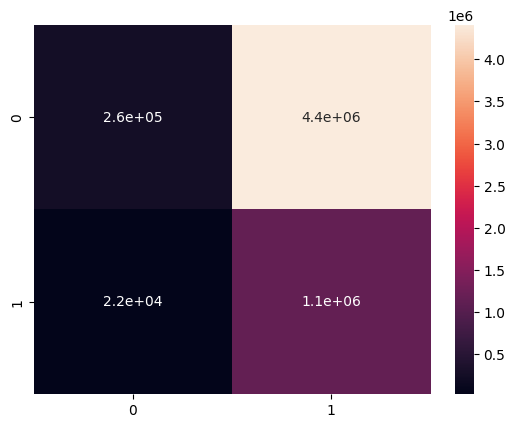

In [81]:
threshold = 0.1

y_scores_rf = rf_pipeline.predict_proba(X_test)
y_pred_rf = np.where(y_scores_rf[:,1] > threshold, 1,0)
conf_mat = confusion_matrix(y_test, y_pred_rf)


precision = conf_mat[1,1]/sum(conf_mat[:,1]) if sum(conf_mat[:,1])>0 else 'Undefined'
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)